In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd
from mkidreadoutanalysis.mkidreadout import MKIDReadout
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
from mkidreadoutanalysis.optimal_filters.config import ConfigThing
import copy
%matplotlib inline

# Table of Contents <a class="anchor" id="table"></a>

[1. Import Data](#import)

[2. Raw Data](#rawdata)
* [2.1 Red Data](#redraw)
    * [2.1.1 FPGA Phase](#redrawphase)
    * [2.1.2 FPGA IQ](#redrawiq)
* [2.2 IR Data](#irraw)
    * [2.2.1 FPGA Phase](#irrawphase)
    * [2.2.2 FPGA IQ](#irrawiq)
* [2.2 Blue Data](#blueraw)
    * [2.2.1 FPGA Phase](#bluerawphase)
    * [2.2.2 FPGA IQ](#bluerawiq)
* [2.3 Dirty R](#dirtyr)
    * [2.3.1 Phase](#dirtyrphase)
    * [2.3.2 IQ](#dirtyriq)
    
[3. Optimal Filters](#optimalfilters)

# 1. Import Data <a class="anchor" id="import"></a>
[Table of Contents](#table)

In [3]:
data = np.load(f'/work/jpsmith/Gen3/Fridge_Tests/r_testing/data/white_fridge/10_18_23/wf_ellison3_6000_650GHz.npz')

dark_phase=data['dark_phase']*np.pi
dark_iq=data['dark_iq'] 
ir_phase=data['ir_phase']*np.pi
ir_iq=data['ir_iq']
red_phase=data['red_phase']*np.pi
red_iq=data['red_iq']
blue_phase=data['blue_phase']*np.pi
blue_iq=data['blue_iq']

# Raw Data  <a class="anchor" id="rawdata"></a>
[Table of Contents](#table)

## Red Data  <a class="anchor" id="redraw"></a>

### FPGA Phase <a class="anchor" id="redrawphase"></a>

#### Set Threshold and Deadtime

In [4]:
red_phase_readout = MKIDReadout()
red_phase_readout.trigger(red_phase, fs = 1e6, threshold=-0.40, deadtime=60)
print(f'Total photons: {(red_phase_readout.trig>0).sum()}')

Total photons: 22302


#### Triggered Phase Timestream

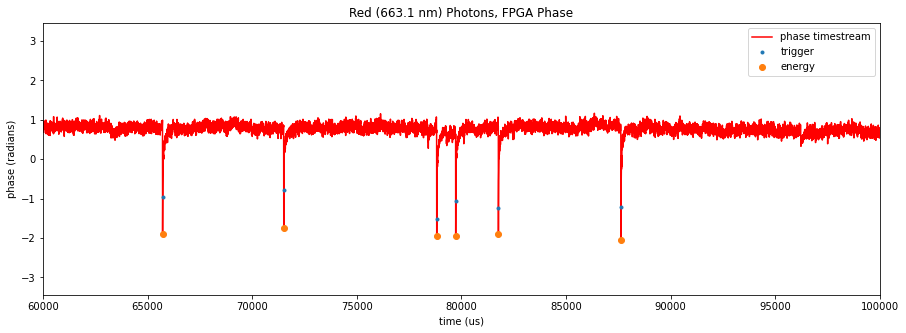

In [5]:
red_phase_readout.plot_triggers(red_phase, fs=1e6, energies=True, color='red')
plt.xlim([60000,100000]);
plt.title('Red (663.1 nm) Photons, FPGA Phase');

## Get Dark Level

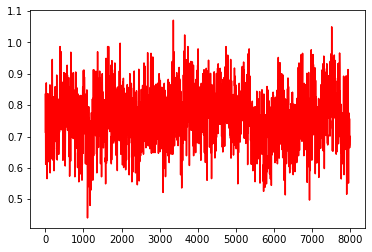

In [6]:
x = slice(10000, 18000)
plt.plot(red_phase[x], color='red')
red_phase_dark_mean = red_phase[x].mean()

#### Phase Histogram

Max Phase: -2.771079054898719 FWHM: 0.19142451688571738 radians


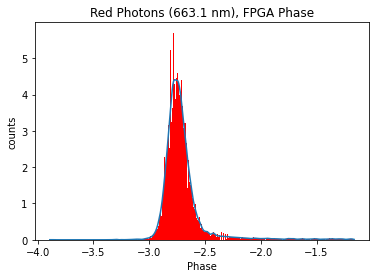

In [7]:
red_phase_max_location, red_phase_fwhm = compute_r(red_phase_readout.photon_energies - red_phase_dark_mean, color='red', plot=True)
print(f'Max Phase: {-red_phase_max_location} FWHM: {red_phase_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA Phase');

### FPGA IQ --> Phase <a class="anchor" id="redrawiq"></a>
[Table of Contents](#table)

#### Set Threshold and Deadtime

In [8]:
red_iq_readout = MKIDReadout()
red_iq_phase = np.angle(red_iq)
red_iq_readout.trigger(red_iq_phase, fs = 1e6, threshold=0.25, deadtime=60)
print(f'Total photons: {(red_iq_readout.trig>0).sum()}')

Total photons: 11059


#### Triggered Phase Timestream

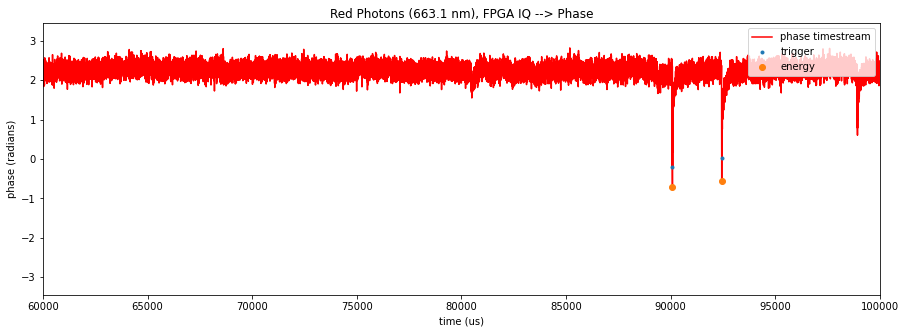

In [9]:
red_iq_readout.plot_triggers(red_iq_phase, fs=1e6, energies=True, color='red')
plt.xlim([60000,100000]);
plt.title('Red Photons (663.1 nm), FPGA IQ --> Phase');

## Get Dark Level

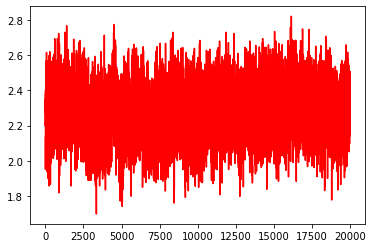

In [10]:
x = slice(10000, 30000)
plt.plot(red_iq_phase[x], color='red')
red_iq_dark_mean = red_iq_phase[x].mean()

#### Phase Histogram

Max Phase: -2.9193591207362166 FWHM: 0.2800585374560325 radians


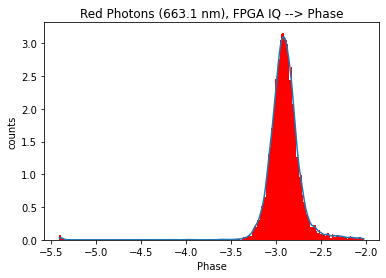

In [11]:
red_iq_max_location, red_iq_fwhm = compute_r(red_iq_readout.photon_energies - red_iq_dark_mean, color='red', plot=True)
print(f'Max Phase: {-red_iq_max_location} FWHM: {red_iq_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA IQ --> Phase');

## IR Data <a class="anchor" id="irraw"></a>
[Table of Contents](#table)

### FPGA Phase <a class="anchor" id="irawphase"></a>

#### Set Threshold and Deadtime

In [12]:
ir_phase_readout = MKIDReadout()
ir_phase_readout.trigger(ir_phase, fs = 1e6, threshold=-0.15, deadtime=60)
print(f'Total photons: {(ir_phase_readout.trig>0).sum()}')

Total photons: 31388


#### Triggered Phase Timestream

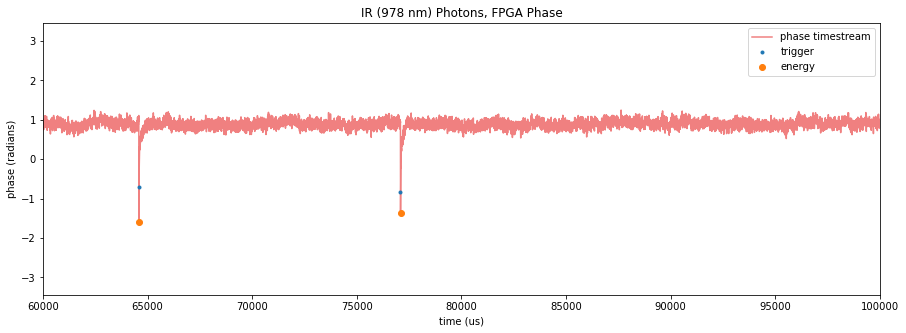

In [13]:
ir_phase_readout.plot_triggers(ir_phase, fs=1e6, energies=True, color='lightcoral')
plt.xlim([60000,100000]);
plt.title('IR (978 nm) Photons, FPGA Phase');

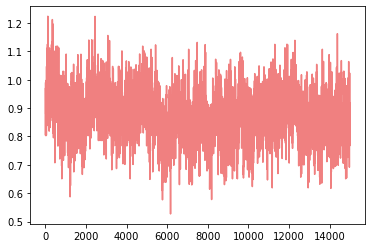

In [14]:
x = slice(35000, 50000)
plt.plot(ir_phase[x], color='lightcoral')
ir_phase_dark_mean = ir_phase[x].mean()

#### Phase Histogram

Max Phase: -2.2987713005625743 FWHM: 0.2361490172423366 radians


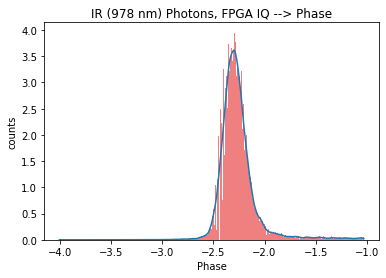

In [15]:
ir_phase_max_location, ir_phase_fwhm = compute_r(ir_phase_readout.photon_energies - ir_phase_dark_mean, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_phase_max_location} FWHM: {ir_phase_fwhm} radians')
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

### FPGA IQ --> Phase <a class="anchor" id="irrawiq"></a>
[Table of Contents](#table)

#### Set Threshold and Deadtime

In [16]:
ir_iq_readout = MKIDReadout()
ir_iq_phase = np.angle(ir_iq)
ir_iq_readout.trigger(ir_iq_phase, fs = 1e6, threshold=0.55, deadtime=60)
print(f'Total photons: {(ir_iq_readout.trig>0).sum()}')

Total photons: 15750


#### Triggered Phase Timestream

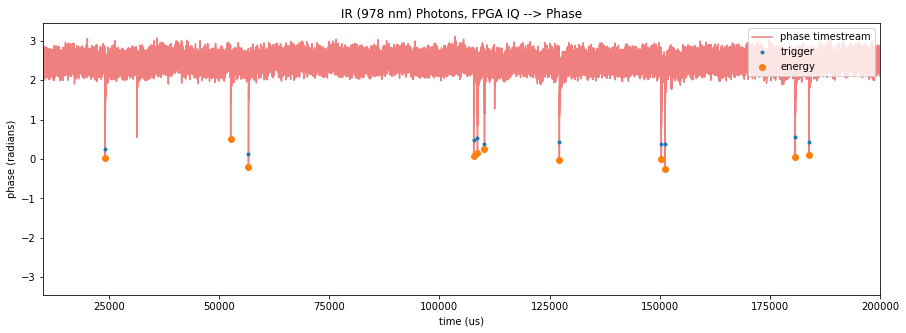

In [17]:
ir_iq_readout.plot_triggers(ir_iq_phase, fs=1e6, energies=True, color='lightcoral')
plt.xlim([10000,200000]);
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

### Get Dark Level

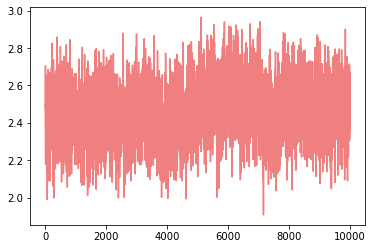

In [18]:
x = slice(10000, 20000)
plt.plot(ir_iq_phase[x], color='lightcoral')
ir_iq_dark_mean = ir_iq_phase[x].mean()

#### Phase Histogram

Max Phase: -2.4917253574229115 FWHM: 0.3112247458672486 radians


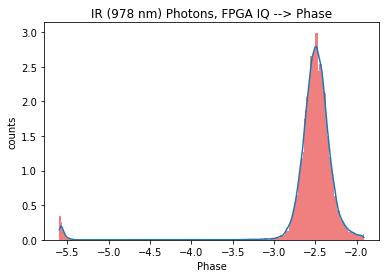

In [19]:
ir_iq_max_location, ir_iq_fwhm = compute_r(ir_iq_readout.photon_energies - ir_iq_dark_mean, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_iq_max_location} FWHM: {ir_iq_fwhm} radians')
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

## Blue Data <a class="anchor" id="blueraw"></a>
[Table of Contents](#table)

### FPGA Phase <a class="anchor" id="bluerawphase"></a>

#### Set Threshold and Deadtime

In [20]:
blue_phase_readout = MKIDReadout()
blue_phase_readout.trigger(blue_phase, fs = 1e6, threshold=-0.8, deadtime=60)
print(f'Total photons: {(blue_phase_readout.trig>0).sum()}')

Total photons: 22133


#### Triggered Phase Timestream

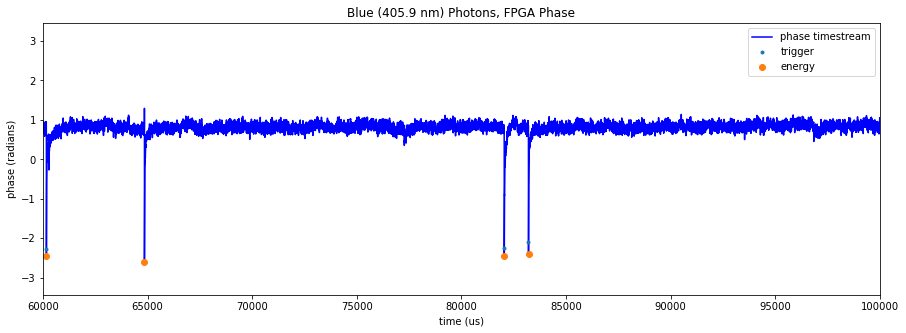

In [21]:
blue_phase_readout.plot_triggers(blue_phase, fs=1e6, energies=True, color='blue')
plt.xlim([60000,100000]);
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

### Get Dark Level

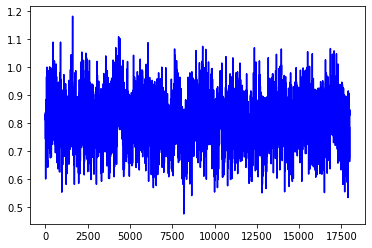

In [22]:
x = slice(42000, 60000)
plt.plot(blue_phase[x],color='blue')
blue_phase_dark_mean = blue_phase[x].mean()

#### Phase Histogram

Max Phase: -3.271328742719113 FWHM: 0.1351108490943127 radians


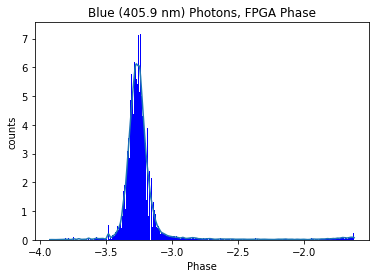

In [23]:
blue_phase_max_location, blue_phase_fwhm = compute_r(blue_phase_readout.photon_energies - blue_phase_dark_mean, color='blue', plot=True)
print(f'Max Phase: {-blue_phase_max_location} FWHM: {blue_phase_fwhm} radians')
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

### FPGA IQ --> Phase <a class="anchor" id="bluerawiq"></a>
[Table of Contents](#table)

#### Set Threshold and Deadtime

In [24]:
blue_iq_readout = MKIDReadout()
blue_iq_phase = np.angle(blue_iq)
blue_iq_readout.trigger(blue_iq_phase, fs = 1e6, threshold=0.25, deadtime=60)
print(f'Total photons: {(blue_iq_readout.trig>0).sum()}')

Total photons: 10778


#### Triggered Phase Timestream

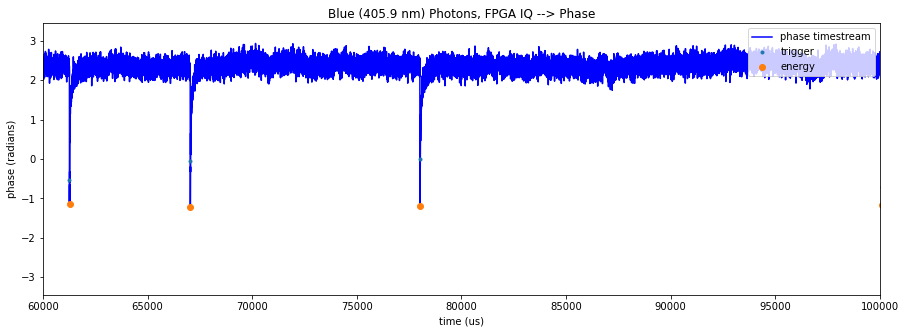

In [25]:
blue_iq_readout.plot_triggers(blue_iq_phase, fs=1e6, energies=True, color='blue')
plt.xlim([60000,100000]);
plt.title('Blue (405.9 nm) Photons, FPGA IQ --> Phase');

#### Get Dark Level

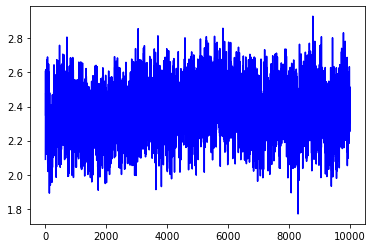

In [26]:
x = slice(10000, 20000)
plt.plot(blue_iq_phase[x], color='blue')
blue_iq_dark_mean = blue_iq_phase[x].mean()

#### Phase Histogram

Max Phase: -3.538689788252541 FWHM: 0.2451925343456014 radians


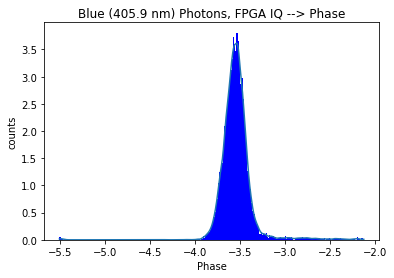

In [27]:
blue_iq_max_location, blue_iq_fwhm = compute_r(blue_iq_readout.photon_energies - blue_iq_dark_mean, color='blue', plot=True)
print(f'Max Phase: {-blue_iq_max_location} FWHM: {blue_iq_fwhm} radians')
plt.title('Blue (405.9 nm) Photons, FPGA IQ --> Phase');

### Centered Phase Timestreams

In [28]:
blue_phase_centered = blue_iq_readout.photon_energies - blue_phase_dark_mean
red_phase_centered = red_iq_readout.photon_energies - red_phase_dark_mean
ir_phase_centered = ir_iq_readout.photon_energies - ir_phase_dark_mean

# Dirty R  <a class="anchor" id="dirtyr"></a>
[Table of Contents](#table)

In [29]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [30]:
lasers = np.array([405.9, 663.1, 978.0])

## Phase Data  <a class="anchor" id="dirtyrphase"></a>

In [31]:
phase_dist_centers = -np.array([blue_phase_max_location, red_phase_max_location, ir_phase_max_location])
phase_dist_fwhm = np.array([blue_phase_fwhm, red_phase_fwhm, ir_phase_fwhm])

dldp = np.diff(lasers)/np.diff(phase_dist_centers)
dl = dldp.mean()*phase_dist_fwhm

Distribution Centers: [-3.27132874 -2.77107905 -2.2987713 ]
Distribution FWHMs: [0.13511085 0.19142452 0.23614902]
Dirty R: [5.0881148  5.86691156 7.01424264]


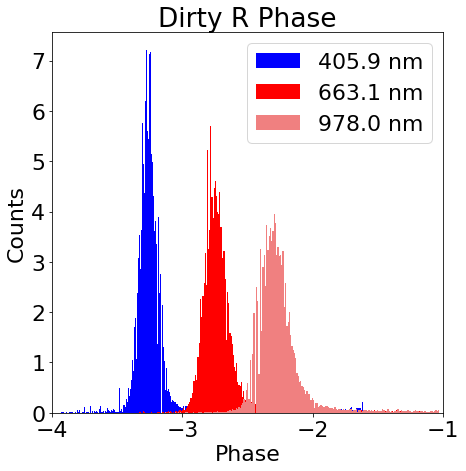

In [32]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.hist(blue_phase_readout.photon_energies - blue_phase_dark_mean, bins='auto', density=True, color='blue', label='405.9 nm');
ax.hist(red_phase_readout.photon_energies - red_phase_dark_mean, bins='auto', density=True, color='red', label='663.1 nm');
ax.hist(ir_phase_readout.photon_energies - ir_phase_dark_mean, bins='auto', density=True, color='lightcoral', label='978.0 nm');
ax.set_xlabel('Phase')
ax.set_xlim([-4,-1])
ax.set_ylabel('Counts')
ax.set_title('Dirty R Phase')
ax.legend(loc='upper right')
print(f'Distribution Centers: {phase_dist_centers}')
print(f'Distribution FWHMs: {phase_dist_fwhm}')
print(f'Dirty R: {lasers/dl}')


## IQ --> Phase Data  <a class="anchor" id="dirtyriq"></a>
[Table of Contents](#table)

In [33]:
phase_iq_dist_centers = -np.array([blue_iq_max_location, red_iq_max_location, ir_iq_max_location])
phase_iq_dist_fwhm = np.array([blue_iq_fwhm, red_iq_fwhm, ir_iq_fwhm])

dldp_iq = np.diff(lasers)/np.diff(phase_iq_dist_centers)
dl_iq = dldp_iq.mean()*phase_iq_dist_fwhm

Distribution Centers: [-3.53868979 -2.91935912 -2.49172536]
Distribution FWHMs: [0.24519253 0.28005854 0.31122475]
Dirty R: [2.87485341 4.11182012 5.45718441]


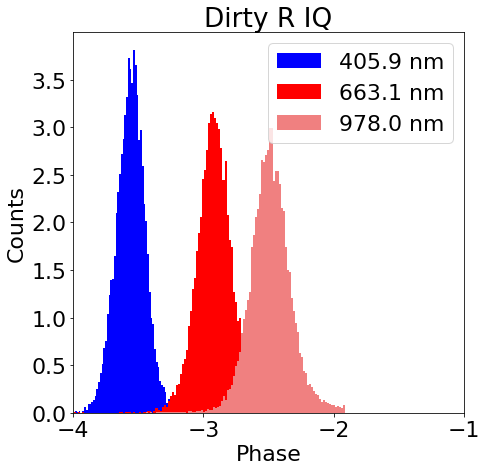

In [34]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.hist(blue_iq_readout.photon_energies - blue_iq_dark_mean, bins='auto', density=True, color='blue', label='405.9 nm');
ax.hist(red_iq_readout.photon_energies - red_iq_dark_mean, bins='auto', density=True, color='red', label='663.1 nm');
ax.hist(ir_iq_readout.photon_energies - ir_iq_dark_mean, bins='auto', density=True, color='lightcoral', label='978.0 nm');
ax.set_xlabel('Phase')
ax.set_ylabel('Counts')
ax.set_xlim([-4,-1])
ax.set_title('Dirty R IQ')
ax.legend(loc='upper right')
print(f'Distribution Centers: {phase_iq_dist_centers}')
print(f'Distribution FWHMs: {phase_iq_dist_fwhm}')
print(f'Dirty R: {lasers/dl_iq}')


# Optimal Filters  <a class="anchor" id="optimalfilters"></a>
[Table of Contents](#table)

In [48]:
 FLAG_DEFS = {'not_started': 0,  # calculation has not been started.
         'pulses_computed': 1,  # finished finding the pulses.
         'noise_computed': 2,  # finished the noise calculation.
         'template_computed': 4,  # finished the template calculation.
         'filter_computed': 8,  # finished the filter calculation.
         'bad_pulses': 16,  # not enough pulses found satisfying the configuration conditions.
         'bad_noise': 32,  # noise calculation failed. Assuming white noise.
         'bad_template': 64,  # template calculation failed. Using the fallback template.
         'bad_template_fit': 128,  # the template fit failed. Using the raw data.
         'bad_filter': 256}  # filter calculation failed. Using the template as a filter.

## Red Data  <a class="anchor" id="ofiltred"></a>

array([<AxesSubplot:title={'center':'successful'}, xlabel='frequency [Hz]', ylabel='PSD [dBc / Hz]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='filter coefficient [radians]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>],
      dtype=object)

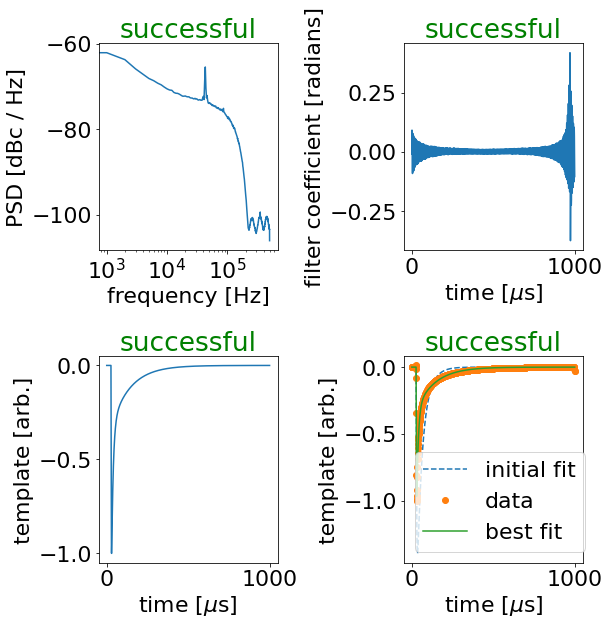

In [35]:
cfg=ConfigThing()
cfg.registerfromkvlist((('dt', 1e-6),
('fit', True),
('summary_plot', True),
('pulses.unwrap', False),
('pulses.fallback_template', 'default'),
('pulses.ntemplate', 1000), # need to set this larger to calculate covariance matrix in the time domain "accurately" for the number of selected filter coefficients
('pulses.offset', 30),
('pulses.threshold', 6), # sigma above noise
('pulses.separation', 80),
('pulses.min_pulses', 1000),
('noise.nwindow', 1000), #1000
('noise.isolation', 200),
('noise.max_windows', 2000), # maximum number of nwindows of samples needed before moving on [int]
('noise.max_noise', 5000), #2000
('template.percent', 80),
('template.cutoff', .2),
('template.min_tau', 5),
('template.max_tau', 100),
('template.fit', 'triple_exponential'),
('filter.filter_type', 'wiener'),
('filter.nfilter', 1000), # for messing around this should be closer to 1000 and ntemplate should be increased to be 5-10x nfilter
                        # need to make sure filter is periodic and this gets hard when the filter is short
('filter.normalize', True)), namespace='')

ofc = Calculator(phase=red_phase, config=cfg, name='simulated')

ofc.calculate(clear=False)

ofc.plot()

In [49]:
ofc.result['flag'] & FLAG_DEFS['pulses_computed']

1

In [50]:
ofc.cfg.pulses

{'unwrap': False,
 'fallback_template': 'default',
 'ntemplate': 1000,
 'offset': 30,
 'threshold': 6,
 'separation': 80,
 'min_pulses': 1000}

### Find pulses

In [139]:
# make a random guess filter
from mkidreadoutanalysis.optimal_filters.filters import matched
starting_filter = matched(ofc.fallback_template, nfilter=1000, dc=True)

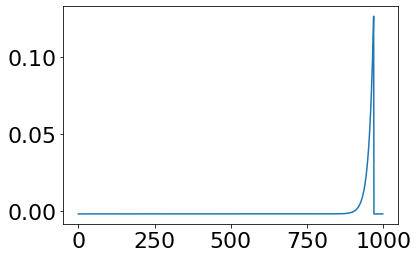

In [140]:
plt.plot(starting_filter)

In [141]:
# filter timestream
import scipy as sp
filtered_phase = sp.signal.convolve(red_phase, -starting_filter, mode='same')

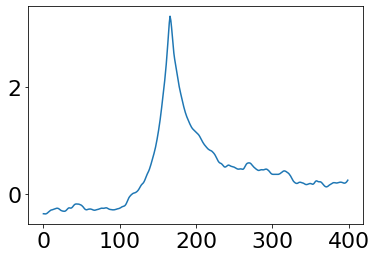

In [150]:
plt.plot(filtered_phase[31300:31700])

In [180]:
from astropy.stats import mad_std
sigma = mad_std(filtered_phase)
threshold = 11
characteristic_time = 100
pulses, properties = sp.signal.find_peaks(filtered_phase, height=threshold * sigma,
                                         distance=10 * characteristic_time)

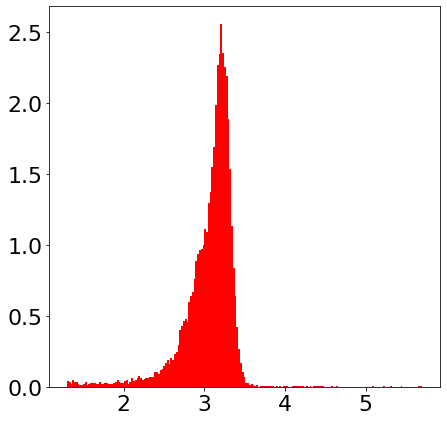

In [181]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.hist(properties['peak_heights'], bins='auto', density=True, color='red');

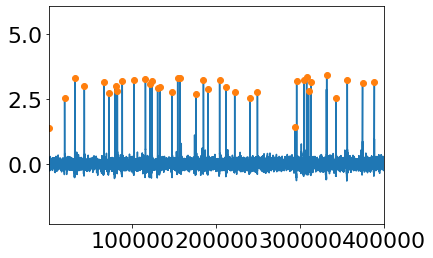

In [182]:
time = np.arange(filtered_phase.shape[0])
plt.plot(time, filtered_phase)
plt.plot(time[pulses], filtered_phase[pulses],"o")
plt.xlim([1000,400000]);

In [183]:
pulses.size

20600

In [36]:
print(f'Found {ofc.result["mask"].sum()} good pulses.')

Found 22809 good pulses.
